In [1]:
from defs import *
device = torch.device(1)
def tt(x, dtype=torch.float, device=device): 
    return torch.tensor(x, dtype=dtype, device=device)
%config InlineBackend.figure_format = 'retina'

### Prepare training and test data

In [2]:
datadate = '20190903'; pl = 6
filepath = '/mnt/sdb1/TwoPhoton/'+datadate+'/'
data = sio.loadmat('/mnt/sdb1/mats/more_' + datadate + '.mat'); fr = data['fr'].item()

sig = fr/5; ker = np.exp(-np.arange(int(4*sig+.5))**2/2/sig**2); ker = ker/sum(ker)
traces = np.apply_along_axis(np.convolve, 1, np.pad(data['F_'], ((0,0), (len(ker)-1,0)), 'edge'), ker, 'valid')
tracep = np.apply_along_axis(gaussian_filter, 1, traces, fr/10) 
N = traces.shape[0]; nGo=int(.5*fr+.5)+1

In [3]:
sl=2; align1, align2, tgs, res, mah, fid = getMarkers(fr, sl, pl, data)
dts, l2 = getDts(fid, sl, fr, nGo); ndts=len(dts)
T2 = tt(tgs-1).long(); R2 = tt(res-1).long()
F2 = getF(traces, align1, dts, nGo)
F2 = F2 - getFm(F2, T2, pl, sl); F2 = tt(F2)
F2_mah = F2[mah==1]; T2_mah = T2[mah==1]
F2_nmh = F2[mah==0]; T2_nmh = T2[mah==0]; R2_nmh = R2[mah==0]

sl=3; align1, align2, tgs, res, mah, fid = getMarkers(fr, sl, pl, data)
dts, l3 = getDts(fid, sl, fr, nGo); ndts=len(dts)
T3 = tt(tgs-1).long(); R3 = tt(res-1).long()
F3 = getF(traces, align1, dts, nGo)
F3 = F3 - getFm(F3, T3, pl, sl); F3 = tt(F3)
F3_mah = F3[mah==1]; T3_mah = T3[mah==1]; 
F3_nmh = F3[mah==0]; T3_nmh = T3[mah==0]; R3_nmh = R3[mah==0]

In [4]:
sl = 3 
if sl==2: 
    F_mah = F2_mah; T_mah = T2_mah; F = F2; l=l2; l23=l3; sl_=3
    labels = ['','T1','','T2','','','','','','','','','Off','R1','R2','','','']
if sl==3: 
    F_mah = F3_mah; T_mah = T3_mah; F = F3; l=l3; l23=l2; sl_=2
    labels = ['','T1','','T2','','T3','','','','','','','','','Off','R1','R2','R3','','','']
ndts = F_mah.shape[1]

### Train decoder and get output distribution

In [ ]:
Nh=2; rnns = []; tgCs=[]
P = {'mw':[20, 0.1], 'rw':3, 'nl':10, 'nw':50, 'lr':1e-3, 'ng':nGo-1, 'sl':sl, 'pl':pl, 'Nh': Nh, 'N':N, 'model':itemNN, 'dv':device}
lstring = datadate +'_N'+ str(P['N']) +'_H'+ str(P['Nh']) +'_rw'+ str(P['rw']) +'_mw'+ str(P['mw']) +'-'+ str(P['lr'])[1:]
tgW = tt(getTrialWeight(T_mah, pl, P['rw'])[1])
for il in range(ndts):
    print('>>>', il); rnn = itemNN(P['N'], P['Nh'], P['nw'], P['sl'], P['mw'], tgW).to(P['dv'])
    trainDecoder(rnn, F_mah[:,il], T_mah, P['nl'], P['ng'], P['lr']); rnns.append(rnn)

In [ ]:
tgCs=[] # use all trials to estimate output distribution
for il in range(ndts):
    rnn = rnns[il] # ndts, nTr, ng, nj, sl
    tp = testDecoder(rnn, F).reshape(ndts, -1, P['sl']) 
    tgCs.append(np.stack([tp==i for i in range(pl)], -1).sum(1)) # ndts, sl, pl
tgCs = np.stack([np.stack(tgCs)]); np.save(filepath + 'tgCs'+str(sl), tgCs)

### Decode item match in error trial

99.5 20190903_N242_H2_rw3_mw[20, 0.1]-.001


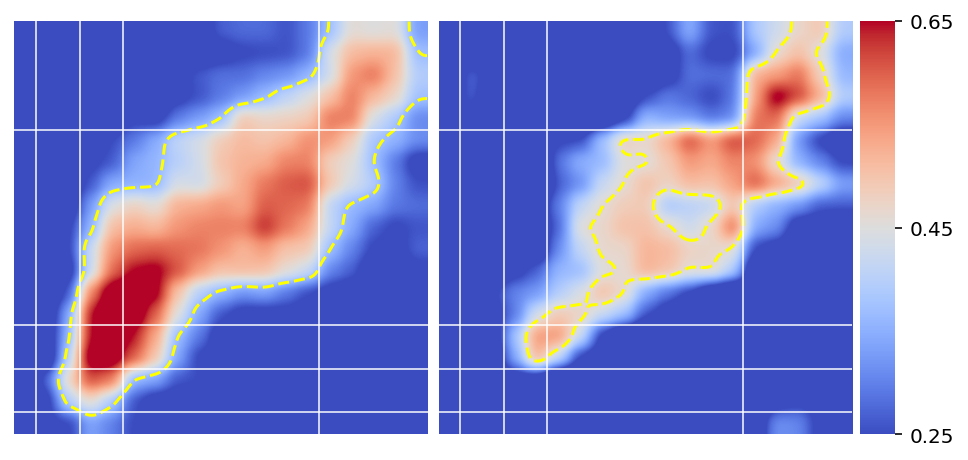

In [11]:
Shfs = []; Accs = []; npct=99.5
for rank in range(2):
    idx3 = R3_nmh[:,rank]==T3_nmh[:,rank]
    Ft = F3_nmh[idx3]; Tt = T3_nmh[idx3]; Ac=[]
    for i in range(ndts): 
        Ac.append(testDecoder1(rnns[i], Ft, Tt[:,rank], rank))
    Accs.append(np.stack(Ac))
    shf = Shuffle(tn(Tt[:,rank]), tgCs[:,:,:,rank], [0, len(Tt)], 0, 1000)
    Shfs.append(shf.runShuffle(50))
Cont = [Accs[i] - np.percentile(Shfs[i], npct) for i in range(2)]
print(npct, lstring); pDecode(Accs, Cont, [.25,.65], [.25,.45,.65], l[:-1], l[:-1], 20, 2) 

### Cross rank decoding

99.5 20190903_N242_H2_rw3_mw[20, 0.1]-.001


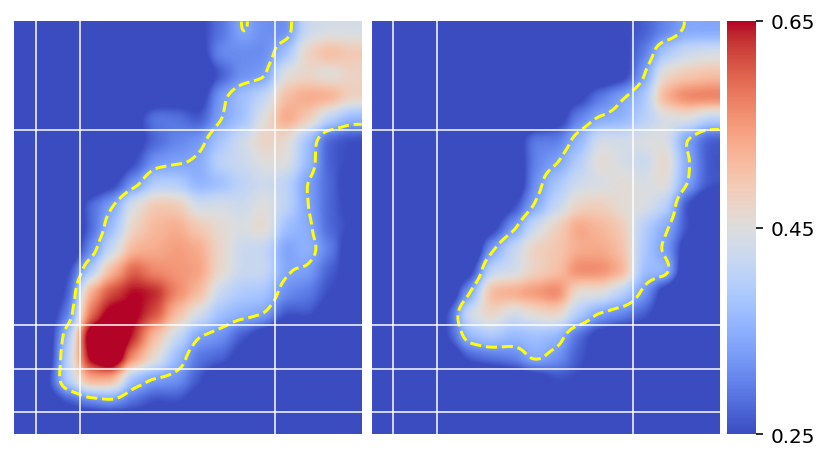

In [12]:
Shfs = []; Accs = []; npct=99.5
for rank in range(2):
    Ft = F2_mah; Tt = T2_mah; Ac=[]
    for i in range(ndts): Ac.append(testDecoder1(rnns[i], Ft, Tt[:,rank], rank))
    shf = Shuffle(tn(Tt[:,rank]), tgCs[:,:,:,rank], [0, len(Tt)], 0, 1000)
    Shfs.append(shf.runShuffle(50)); Accs.append(np.stack(Ac))
Cont = [Accs[i] - np.percentile(Shfs[i], npct) for i in range(2)]
print(npct, lstring); pDecode(Accs, Cont, [.25,.65], [.25,.45,.65], l[:-1], l23[:-1], 20, 2) 

In [34]:
def pEvs(Nh): # plot explained variance
    evs = []; evs_=[]; yl = 6
    for ll in l: plt.axvline(ll,lw=1,ls=':',c='gray')
    for il in range(ndts): 
        W = tn(rnns[il].Wi); Vr, S, _ = np.linalg.svd(tn(F_mah[:,il]).reshape(-1,N).T); Sr = S**2
        for i in range(len(W)):    # note that we should not  dmean here
            for j in range(W.shape[1]):
                Vt = np.linalg.svd(W[i,j].T)[-1]; evs.append(sum(Sr@((Vt[:Nh]@Vr)**2).T)/sum(Sr)*100)
                Vt = np.linalg.svd(np.random.randn(Nh,N))[-1]; evs_.append(sum(Sr@((Vt[:Nh]@Vr)**2).T)/sum(Sr)*100)
    evs = np.array(evs).reshape(ndts,sl,-1); evs_ = np.array(evs_).reshape(ndts,-1).mean(-1)
    print(evs.shape)
    for rank in range(sl):
        plt.errorbar(np.arange(ndts)-.65+rank*.15, evs[:,rank].mean(-1), np.std(evs[:,rank],-1), capsize=3, capthick=2, c=Cs[rank])
    plt.plot(np.arange(ndts)-.5, evs_, ls='--', c='gray')
    plt.ylim(0.5,yl); plt.xlim(left=-1,right=ndts-1)
    plt.xticks([l[0],l[1],l[2],l[-2]-4.5,l[-2],l[-1]],['T1','T2','T3','delay','Go','R3'], fontsize=f_s+1)
    plt.yticks([1,2,3,4,5,6], fontsize=f_s-1); plt.ylabel('Rank subspace EV (%)', fontsize=f_s+3, labelpad=10)
    ax = plt.gca()
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(('outward', 5)); ax.spines['left'].set_bounds(0.5, yl*1.05)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.tick_params(axis='both', which='major', labelsize=f_s-2)

### Plot explained variance

(19, 3, 50)


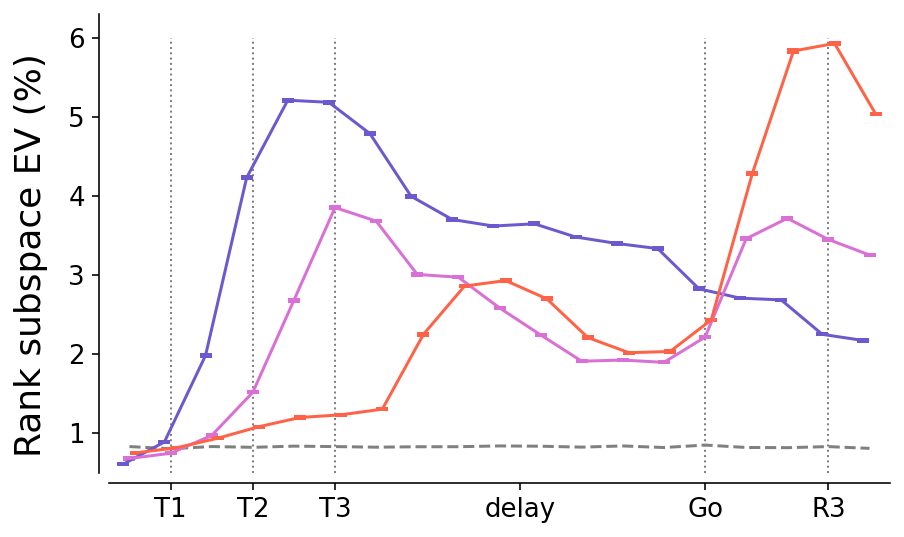

In [35]:
f_s=15; Cs = ['slateblue', 'orchid', 'tomato']; pf(7,4); pEvs(2); 

In [36]:
nd = 2; Sors=[]; Fs=[]; nj = len(rnn.j)
rands = [np.random.choice(range(nj),nj,replace=False) for _ in range(sl)]
for il in range(ndts):
    rnn = rnns[il]
    for i in range(sl):
        W = tn(rnn.Wi[i])
        for j in range(nj):
            W_ = W[rnn.j[rands[i][j]]].T
            _,_,Vt = np.linalg.svd(W_); Fs.append(Vt[:nd].T)
Fs = np.stack(Fs).reshape(ndts, sl, nj, N, nd) 
    
for ii in range(sl):
    for jj in range(sl):
        SOR = np.zeros((ndts,ndts))
        for n in range(nj):
            for i in range(ndts):
                x0 = tn(F_mah[:,i]).reshape(-1,N).T
                F1 = Fs[i,ii,n]; x1 = F1@(F1.T@x0)
                for j in range(ndts):
                    F2 = Fs[j,jj,n]; x2 = F2@(F2.T@x1)
                    SOR[i,j] += np.var(x2)/np.var(x1)/nj
        Sors.append(SOR)

### Plot variance accounted for ratio

20190903_N242_H2_rw3_mw[20, 0.1]-.001


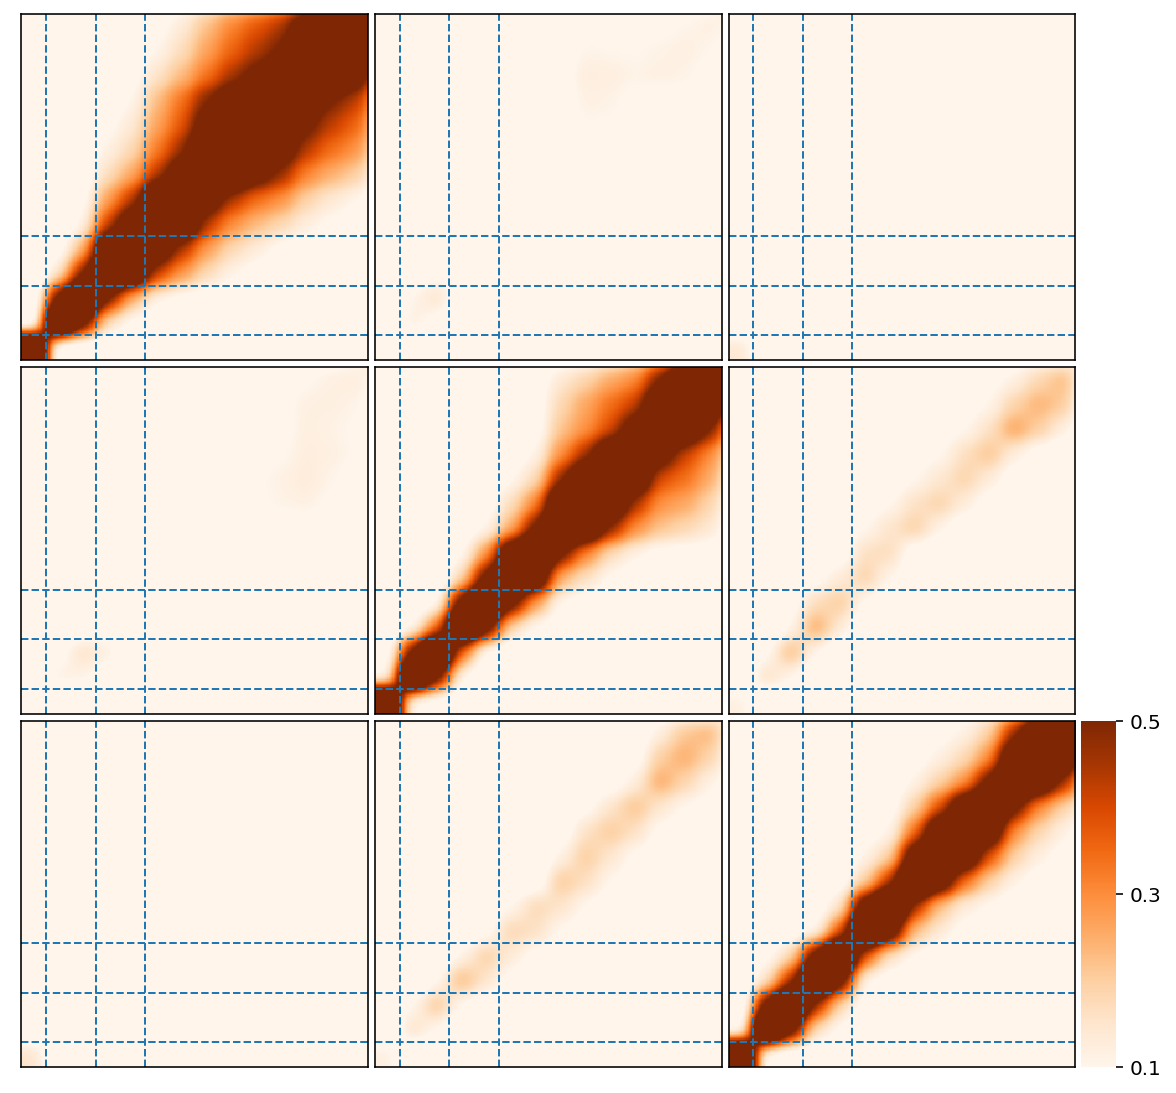

In [38]:
print(lstring); pDecodeSOR(Sors, [.1,.5], [.1,.3,.5], l[:-2], 20, 3, [0,-5]) 